In [1]:
import sys
import os
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from scale_rl.common.wandb_utils import *

/home/leehojoon/.pyenv/versions/3.9.5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Collect Results

In [4]:
simba_v1_eval_df = pd.read_csv(
    "../results/simba_v1_minibench.csv",
    index_col=0
)
simba_v1_eval_df

,exp_name,env_name,seed,metric,env_step,value
0,simba_v1_rr2,h1_stand_v0,9000,avg_return,0.0,17.762764
1,simba_v1_rr2,h1_stand_v0,9000,avg_return,50000.0,42.715274
2,simba_v1_rr2,h1_stand_v0,9000,avg_return,100000.0,73.199464
3,simba_v1_rr2,h1_stand_v0,9000,avg_return,150000.0,326.190074
4,simba_v1_rr2,h1_stand_v0,9000,avg_return,200000.0,628.435240
...,...,...,...,...,...,...
11875,simba_v1_rr2,acrobot_swingup,0,avg_success,300000.0,0.000000
11876,simba_v1_rr2,acrobot_swingup,0,avg_success,350000.0,0.000000
11877,simba_v1_rr2,acrobot_swingup,0,avg_success,400000.0,0.000000
11878,simba_v1_rr2,acrobot_swingup,0,avg_success,450000.0,0.000000


In [5]:
entity = 'joonleesky'
project_name = 'simba'
run_exp_names_to_analysis_exp_names = {
    'simba_v1_rr1_postF_dim1x_simnormT_level4_projT_dim1x_lr1e4': 'rr1_simnorm_level4_proj',
    'simba_v1_rr1_postF_dim1x_simnormT_level8_projT_dim1x_lr1e4': 'rr1_simnorm_level8_proj',
    'simba_v1_rr1_postF_dim1x_simnormT_level16_projT_dim1x_lr1e4':'rr1_simnorm_level16_proj',
    'simba_v1_rr1_postT_dim1x_simnormT_level4_projT_dim1x_lr1e4': 'rr1_simnorm_level4_post_proj',
    'simba_v1_rr1_postT_dim1x_simnormT_level8_projT_dim1x_lr1e4': 'rr1_simnorm_level8_post_proj',
    'simba_v1_rr1_postF_dim1x_simnormT_level4': 'rr1_simnorm_level4',
    'simba_v1_rr1_postF_dim1x_simnormT_level8': 'rr1_simnorm_level8',
    'simba_v1_rr1_postT_dim2x_simnormT_level4': 'rr1_simnorm_level4_post',
    'simba_v1_rr1_postT_dim2x_simnormT_level8': 'rr1_simnorm_level8_post',
}
run_exp_names = list(run_exp_names_to_analysis_exp_names.keys())
metrics = ['avg_return', 'avg_success']

In [6]:
runs = collect_runs(entity=entity, project_name=project_name) 
filtered_runs = filter_runs(runs, exp_names = run_exp_names)
wandb_df = convert_runs_to_dataframe(
    runs = filtered_runs, 
    run_exp_name_to_analysis_exp_name=run_exp_names_to_analysis_exp_names
)
wandb_df = wandb_df[wandb_df.apply(lambda row: 'finished' in str(row['run']), axis=1)]
eval_df = convert_wandb_df_to_eval_df(wandb_df, metrics)
eval_df

5447it [00:48, 112.77it/s]                          
100%|██████████| 502/502 [04:24<00:00,  1.90it/s]


,exp_name,env_name,seed,metric,env_step,value
0,rr1_simnorm_level8_post_proj,h1-stand-v0,4000,avg_return,0.0,31.297300
1,rr1_simnorm_level8_post_proj,h1-stand-v0,4000,avg_return,50000.0,32.122001
2,rr1_simnorm_level8_post_proj,h1-stand-v0,4000,avg_return,100000.0,61.900037
3,rr1_simnorm_level8_post_proj,h1-stand-v0,4000,avg_return,150000.0,77.890074
4,rr1_simnorm_level8_post_proj,h1-stand-v0,4000,avg_return,200000.0,387.673180
...,...,...,...,...,...,...
17339,rr1_simnorm_level4_post,acrobot-swingup,0,avg_success,300000.0,0.000000
17340,rr1_simnorm_level4_post,acrobot-swingup,0,avg_success,350000.0,0.000000
17341,rr1_simnorm_level4_post,acrobot-swingup,0,avg_success,400000.0,0.000000
17342,rr1_simnorm_level4_post,acrobot-swingup,0,avg_success,450000.0,0.000000


In [7]:
eval_df = pd.concat([eval_df, simba_v1_eval_df])

In [8]:
exp_names = eval_df['exp_name'].unique()

#### Visualize Results

In [9]:
from rliable import library as rly
from rliable import metrics as rly_metrics
from rliable import plot_utils as rly_plot_utils

aggregate_func = lambda x: np.array([
  rly_metrics.aggregate_iqm(x),
  rly_metrics.aggregate_median(x),
  rly_metrics.aggregate_mean(x),
  rly_metrics.aggregate_optimality_gap(x/1000)])

In [10]:
from scale_rl.envs.dmc import DMC_EASY_MEDIUM, DMC_HARD
from scale_rl.envs.humanoid_bench import HB_LOCOMOTION_NOHAND
from scale_rl.envs.myosuite import MYOSUITE_TASKS

In [11]:
def replace_hypen_to_underbar(env_name_list):
    for idx in range(len(env_name_list)):
        env_name_list[idx] = env_name_list[idx].replace('-', '_')
    return env_name_list

DMC_EM = replace_hypen_to_underbar(DMC_EASY_MEDIUM)
DMC_HARD = replace_hypen_to_underbar(DMC_HARD)
MYOSUITE_TASKS = replace_hypen_to_underbar(MYOSUITE_TASKS)
HB_LOCOMOTION_NOHAND = replace_hypen_to_underbar(HB_LOCOMOTION_NOHAND)
eval_df['env_name'] = eval_df['env_name'].str.replace('-', '_')
eval_df

,exp_name,env_name,seed,metric,env_step,value
0,rr1_simnorm_level8_post_proj,h1_stand_v0,4000,avg_return,0.0,31.297300
1,rr1_simnorm_level8_post_proj,h1_stand_v0,4000,avg_return,50000.0,32.122001
2,rr1_simnorm_level8_post_proj,h1_stand_v0,4000,avg_return,100000.0,61.900037
3,rr1_simnorm_level8_post_proj,h1_stand_v0,4000,avg_return,150000.0,77.890074
4,rr1_simnorm_level8_post_proj,h1_stand_v0,4000,avg_return,200000.0,387.673180
...,...,...,...,...,...,...
11875,simba_v1_rr2,acrobot_swingup,0,avg_success,300000.0,0.000000
11876,simba_v1_rr2,acrobot_swingup,0,avg_success,350000.0,0.000000
11877,simba_v1_rr2,acrobot_swingup,0,avg_success,400000.0,0.000000
11878,simba_v1_rr2,acrobot_swingup,0,avg_success,450000.0,0.000000


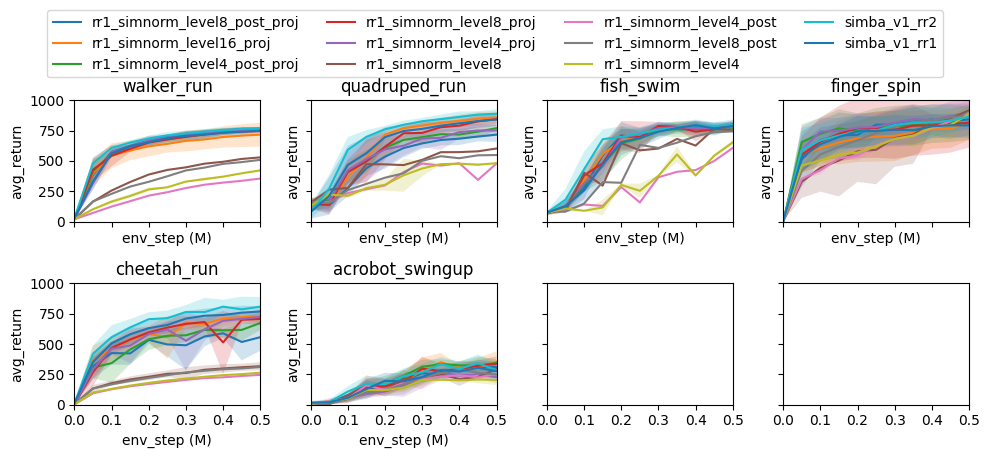

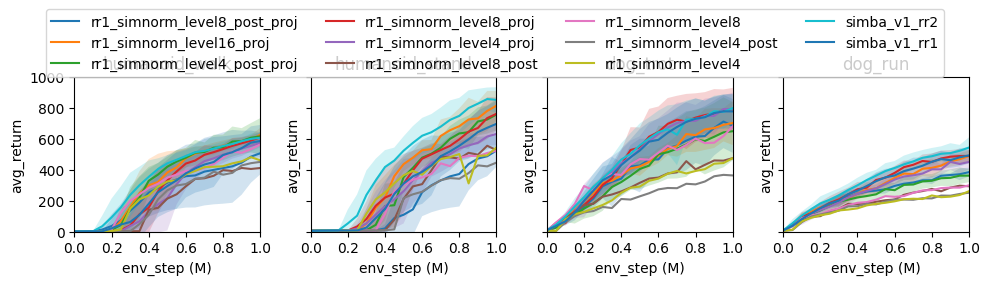

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1

In [12]:
metric_matrix_dict = None

for env_type in ['DMC_EM', 'DMC_HARD', 'MYOSUITE', 'HB_LOCOMOTION_NOHAND']:
    if env_type == 'DMC_EM':
        env_list = DMC_EM
        env_step = 5e5
        metric_type = 'avg_return'
        plot_height=4
        y_lim_max=1000

    elif env_type == 'DMC_HARD':
        env_list = DMC_HARD
        env_step = 1e6
        metric_type = 'avg_return'
        plot_height=2.5
        y_lim_max=1000

    elif env_type == 'MYOSUITE':
        env_list = MYOSUITE_TASKS
        env_step = 1e6
        metric_type = 'avg_success'
        plot_height=2.5
        y_lim_max=1.1

    elif env_type == 'HB_LOCOMOTION_NOHAND':
        env_list = HB_LOCOMOTION_NOHAND
        env_step = 1e6
        metric_type = 'avg_return'
        plot_height=2.5
        y_lim_max=1000

    _eval_df = eval_df[eval_df['env_name'].isin(env_list)]
    
    plot_metric_history_per_env(
        _eval_df,
        num_plots_per_row=4,
        metric=metric_type,
        x_lim_max=env_step,
        y_lim_max=y_lim_max,
        plot_width=10,
        plot_height=plot_height,
        y_label=metric_type,
    )

    # to match the scale of success to the return in comparison
    if metric_type == 'avg_success':
        _eval_df.loc[:, 'value'] *= 1000.0

    _metric_matrix_dict = generate_metric_matrix_dict(
        _eval_df, 
        env_step=env_step,
        metric_type=metric_type,
    )

else: for key, arr2 in _metric_matrix_dict.items(): if key in metric_matrix_dict: arr1 = metric_matrix_dict[key] min_cols = min(arr1.shape[1], arr2.shape[1]) metric_matrix_dict[key] = np.concatenate( (arr1[:, :min_cols], arr2[:, :min_cols]), axis=0 ) else: metric_matrix_dict[key] = arr2.copy()

    if metric_matrix_dict is None:
        metric_matrix_dict = _metric_matrix_dict
    else:
        for key, arr2 in _metric_matrix_dict.items(): 
            if key in metric_matrix_dict: 
                arr1 = metric_matrix_dict[key] 
                min_cols = min(arr1.shape[1], arr2.shape[1]) 
                metric_matrix_dict[key] = np.concatenate( 
                    (arr1[:, :min_cols], arr2[:, :min_cols]), axis=0 
                ) 
            else: metric_matrix_dict[key] = arr2.copy()
        metric_matrix_dict = {
            key: np.concatenate((metric_matrix_dict[key], _metric_matrix_dict[key]), 0) 
            for key in metric_matrix_dict
        }

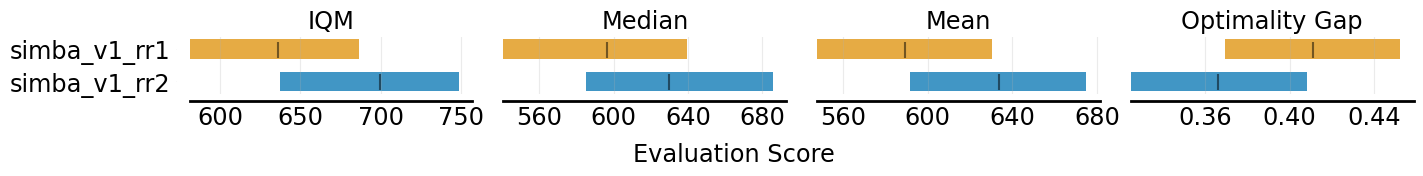

In [12]:
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
    metric_matrix_dict, aggregate_func, reps=10000)

fig, axes = rly_plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=['IQM', 'Median', 'Mean', 'Optimality Gap'],
    algorithms=exp_names,
    xlabel_y_coordinate=-0.8,
    xlabel='Evaluation Score',
)